In [17]:
pip install gensim

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("/Users/matthew941/Desktop/KORE208_team5/3. 정치인별 빈도, 워드임베딩/1.이재명/이재명_tagged_filtered_ver2.csv")

In [19]:
import re

tokenized_sentences = [
    [token for token in sentence.split() if token.split("(")[0].lower() != "vs"]
    for sentence in df['tagged'].dropna()
]

In [20]:
from gensim.models import Word2Vec

# 형태소 분석된 문장에서 단어만 추출 (ex: '라디오(NNG)' → '라디오') + 'vs' 삭제
sentences = df['tagged'].dropna().tolist()

# 제외하고 싶은 단어
ban_words = {"vs", "였고", "D", "이", "엿새", "보름", "열흘", "연이틀", "뉴시스","후보"}
ban_tags = {"VCP", "SL"}

# 필터링
tokenized_sentences = [
    [
        token.split('(')[0]
        for token in sentence.split()
        if token.split('(')[0].lower() not in ban_words and token.split('(')[-1][:-1] not in ban_tags
    ]
    for sentence in sentences
]


# Word2Vec 학습 (Skip-gram, sg=1)
model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,
    window=5,
    min_count=3,
    sg=1,
    workers=4,
    seed=42
)

# Word2Vec에 실제 들어간 단어만 기준으로 딕셔너리 생성
word_to_tag = {}

for sentence in df['tagged'].dropna():
    for token in sentence.split():
        if "(" in token and ")" in token:
            word, tag = token.rsplit("(", 1)
            tag = tag.rstrip(")")
            # 단어가 Word2Vec 학습에 실제 포함된 경우만
            if word in model.wv and word not in word_to_tag:
                word_to_tag[word] = tag



# 이재명과 유사한 단어 50개 추출

keyword = '이재명'

if keyword in model.wv:
    similar_words = model.wv.most_similar(keyword, topn=50)
    print(f"\n[{keyword}]과 유사한 단어 (품사 포함):")
    for word, sim in similar_words:
        tag = word_to_tag.get(word, "UNKNOWN")  # 품사 없으면 'UNKNOWN'으로 출력
        print(f"  {word} ({tag}) - {sim:.3f}")
else:
    print(f"'{keyword}' 단어가 Word2Vec vocabulary에 없습니다.")


[이재명]과 유사한 단어 (품사 포함):
  풍경 (NNG) - 0.633
  대선 (NNG) - 0.631
  월미도 (NNP) - 0.626
  붙잡 (VV-R) - 0.620
  더불어민주당 (NNP) - 0.616
  획득 (NNG) - 0.616
  신승 (NNG) - 0.606
  다자 (NNG) - 0.605
  대선판 (NNG) - 0.605
  여전 (XR) - 0.605
  오마이포토 (NNP) - 0.603
  파이팅 (NNG) - 0.599
  침울 (XR) - 0.598
  정지윤 (NNP) - 0.597
  시엔 (NNP) - 0.597
  캡쳐 (NNP) - 0.595
  보강 (NNG) - 0.595
  홍성군 (NNP) - 0.594
  확실시 (NNG) - 0.594
  독주 (NNG) - 0.594
  오폐수 (NNG) - 0.592
  각축 (NNG) - 0.591
  스코어 (NNG) - 0.589
  화답 (NNG) - 0.589
  숲길 (NNG) - 0.588
  일제히 (MAG) - 0.587
  제치 (VV) - 0.586
  개혁신당 (NNP) - 0.586
  하락세 (NNG) - 0.586
  조선노동당 (NNP) - 0.584
  방사 (NNG) - 0.584
  경상남도 (NNP) - 0.583
  일침 (NNG) - 0.583
  대진표 (NNG) - 0.583
  김우석 (NNP) - 0.582
  어대명어차피 (NNP) - 0.582
  제격 (NNG) - 0.582
  발끈 (MAG) - 0.582
  김지호 (NNP) - 0.582
  보터 (NNG) - 0.581
  불쏘시개 (NNG) - 0.580
  朴 (SH) - 0.579
  아산시 (NNP) - 0.578
  선명히 (MAG) - 0.577
  안방 (NNG) - 0.577
  이래 (NNG) - 0.576
  간극 (NNG) - 0.576
  맞수 (NNG) - 0.576
  맞붙 (VV) - 0.576
  하남시 (NNP) - 0

zsh:1: command not found: pip
zsh:1: command not found: pip


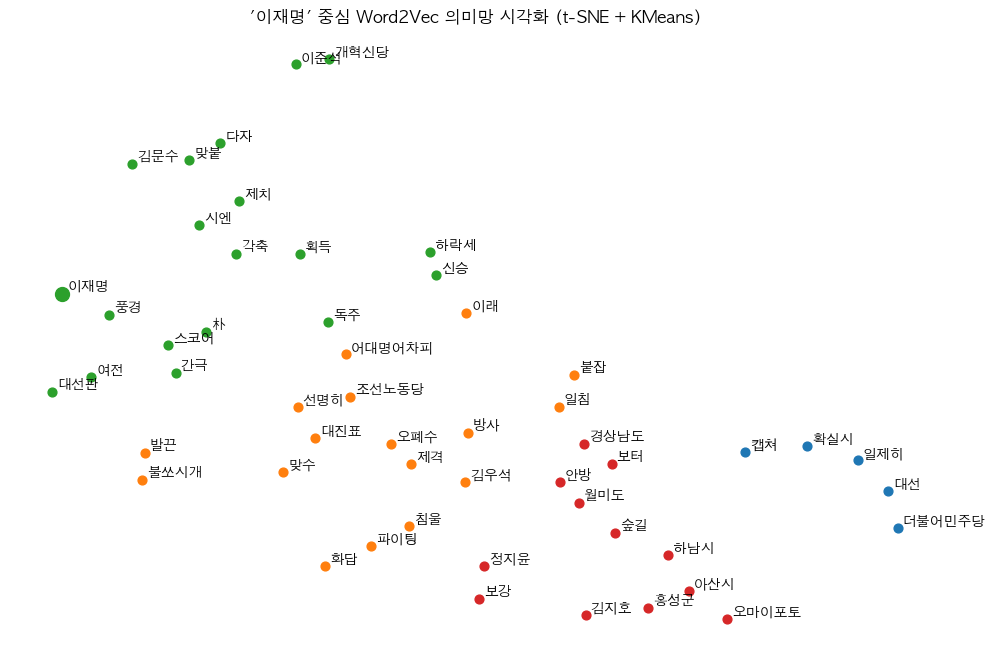

In [21]:
# 2D

import numpy as np

!pip install scikit-learn
!pip install matplotlib

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl
import platform

# 폰트 지정
# mpl.rcParams['font.family'] = 'Malgun Gothic'
# mpl.rcParams['axes.unicode_minus'] = False

# macOS인 경우 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

# 유사 단어 50개
similar_tuples = model.wv.most_similar(keyword, topn=50)
similar_words = [keyword] + [word for word, _ in similar_tuples]

# 필수 단어 포함
must_include = ['이준석', '김문수']
for word in must_include:
    if word not in similar_words and word in model.wv:
        similar_words.append(word)

# 벡터 추출
word_vectors = np.array([model.wv[word] for word in similar_words])

# t-SNE 차원 축소 (★ n_iter 제거함!)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
vec_2d = tsne.fit_transform(word_vectors)

# KMeans 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(vec_2d)

# 시각화
plt.figure(figsize=(12, 8))
for i, word in enumerate(similar_words):
    x, y = vec_2d[i]
    plt.scatter(x, y, c=f"C{labels[i]}", s=100 if word == keyword else 40)
    plt.text(x + 0.5, y + 0.5, word, fontsize=10)
plt.title(f"'{keyword}' 중심 Word2Vec 의미망 시각화 (t-SNE + KMeans)")
plt.axis('off')
plt.show()

zsh:1: command not found: pip
zsh:1: command not found: pip


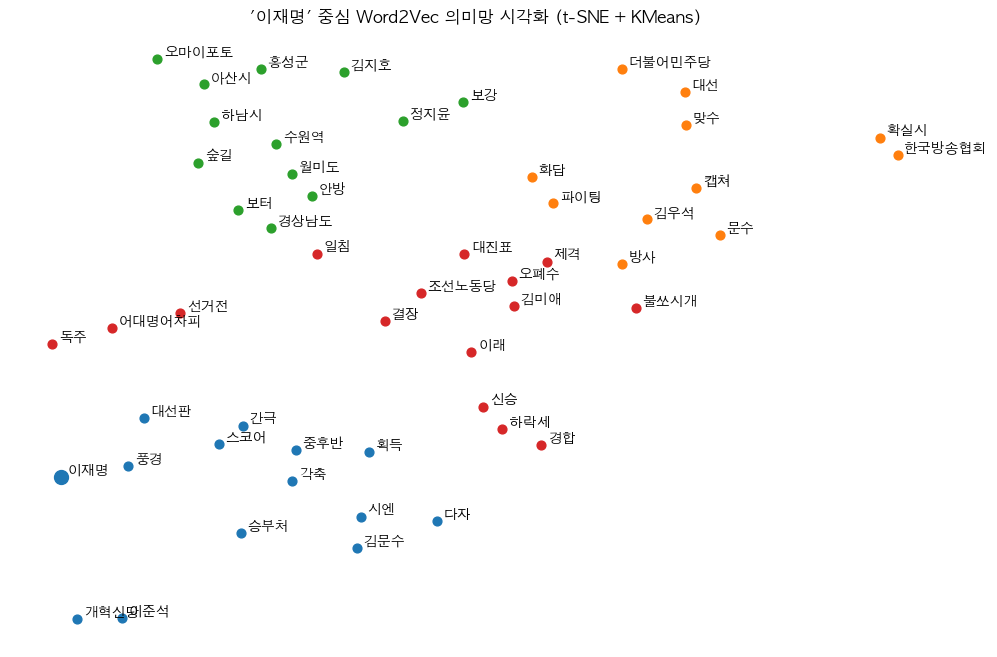

In [22]:
# 2D + 명사만

import numpy as np

!pip install scikit-learn
!pip install matplotlib

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl
import platform

# 폰트 지정
# mpl.rcParams['font.family'] = 'Malgun Gothic'
# mpl.rcParams['axes.unicode_minus'] = False

# macOS인 경우 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

# 유사 단어 50개
all_similar = model.wv.most_similar(keyword, topn=500)  # 넉넉하게 뽑기
noun_similar = [word for word, sim in all_similar if word_to_tag.get(word, "").startswith("NN")]

# 최종 유사 단어 리스트: 중심 단어 + 명사 50개
similar_words = [keyword] + noun_similar[:50]

# 필수 단어 포함
must_include = ['이준석', '김문수']
for word in must_include:
    if word not in similar_words and word in model.wv:
        similar_words.append(word)

# 벡터 추출
word_vectors = np.array([model.wv[word] for word in similar_words])

# t-SNE 차원 축소 (★ n_iter 제거함!)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
vec_2d = tsne.fit_transform(word_vectors)

# KMeans 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(vec_2d)


# 시각화
plt.figure(figsize=(12, 8))

for i, word in enumerate(similar_words):
    x, y = vec_2d[i]
    tag = word_to_tag.get(word, "UNK")

    plt.scatter(x, y, c=f"C{labels[i]}", s=100 if word == keyword else 40)
    plt.text(x + 0.5, y + 0.5, f"{word}", fontsize=10)

plt.title(f"'{keyword}' 중심 Word2Vec 의미망 시각화 (t-SNE + KMeans)")
plt.axis('off')
plt.show()

In [24]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 16.3 MB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 359 kB 110.8 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [25]:
# 3D

import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.io as pio

# 🔧 브라우저로 출력되도록 설정
pio.renderers.default = "browser"

# 1. 유사 단어 추출
similar_tuples = model.wv.most_similar(keyword, topn=50)
similar_words = [keyword] + [word for word, _ in similar_tuples]
word_vectors = np.array([model.wv[word] for word in similar_words])

# 2. 3차원 t-SNE
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
vec_3d = tsne.fit_transform(word_vectors)

# 3. KMeans 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(vec_3d)

# 4. Plotly 시각화
fig = go.Figure()

for i in range(4):
    idx = [j for j, label in enumerate(labels) if label == i]
    fig.add_trace(go.Scatter3d(
        x=vec_3d[idx, 0],
        y=vec_3d[idx, 1],
        z=vec_3d[idx, 2],
        mode='markers+text',
        marker=dict(size=[10 if similar_words[j] == keyword else 5 for j in idx]),
        text=[similar_words[j] for j in idx],
        name=f'Cluster {i+1}',
        textposition='top center'
    ))

fig.update_layout(
    title=f"'{keyword}' 중심 Word2Vec 의미망 시각화 (3D t-SNE + KMeans)",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()